In [34]:
import torch
import torch.nn as nn

import tensorflow as tf

import matplotlib.pyplot as plt
from tqdm.autonotebook import tqdm
import numpy as np
import cv2

import random
import importlib

from sklearn.linear_model import LinearRegression

from NeuralGraph import NeuralGraph

In [35]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()

x_train, x_test = x_train/255.0, x_test/255.0

SIZE = 7

# Digits 0-7 are used for training
train = {i:[] for i in range(8)}
# Digits 8 and 9 are used for testing
test = {i:[] for i in range(8, 10)}

for img, label in zip(x_train, y_train):
    if label < 8:
        train[label].append(cv2.resize(img, dsize=[SIZE, SIZE]).reshape(SIZE**2))
    else:
        test[label].append(cv2.resize(img, dsize=[SIZE, SIZE]).reshape(SIZE**2))


(x_train, y_train), (x_test, y_test) = tf.keras.datasets.fashion_mnist.load_data()

x_train, x_test = x_train/255.0, x_test/255.0

# Use fashion MNIST for out of distribution testing too
fashion_test = {i:[] for i in range(10)}

for img, label in zip(x_train, y_train):
    fashion_test[label].append(cv2.resize(img, dsize=[SIZE, SIZE]).reshape(SIZE**2))

for label in train.keys():
    train[label] = np.array(train[label])

for label in test.keys():
    test[label] = np.array(test[label])

for label in fashion_test.keys():
    fashion_test[label] = np.array(fashion_test[label])

dict_keys([0, 1, 2, 3, 4, 5, 6, 7])


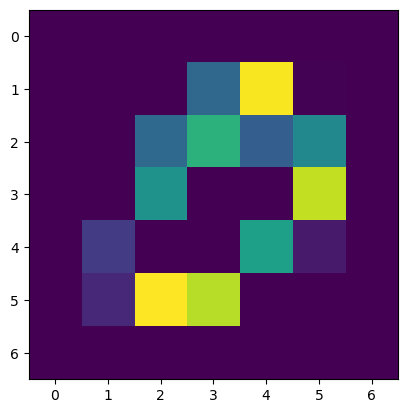

dict_keys([8, 9])


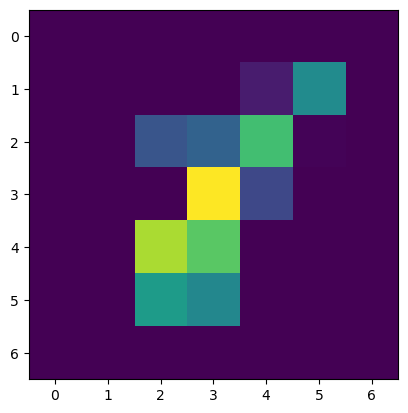

dict_keys([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])


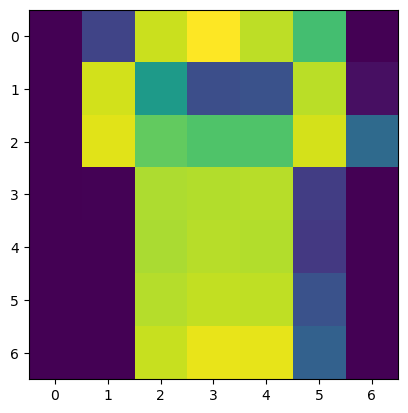

In [36]:
print(train.keys())
plt.imshow(train[0][0].reshape(SIZE, SIZE))
plt.show()

print(test.keys())
plt.imshow(test[8][0].reshape(SIZE, SIZE))
plt.show()

print(fashion_test.keys())
plt.imshow(fashion_test[0][0].reshape(SIZE, SIZE))
plt.show()

In [37]:
BATCH_SIZE = 32
TIME = 1
DT = .25

n_classes = 2
device = "cuda" if torch.cuda.is_available() else "cpu"

# Dense network with 49 nodes
n_nodes = SIZE**2+n_classes
connections = [(x, y) for x in range(n_nodes) for y in range(n_nodes)]
print(len(connections))


# GRAPH WAS INITIALLY TRAINED WITH DECAY = .5 AND SLOWLY RAMPED TO DECAY = .2
# IF TRAINING FROM SCRATCH SET DECAY = .5 AND IF LOADING SET DECAY = .2
graph = NeuralGraph(n_nodes, SIZE**2, n_classes, connections, 
    leakage=.25, ch_n=8, ch_e=8, ch_k=8, value_init="trainable", init_value_std=.1, 
    clamp_mode="hard", max_value=100, # BC I trained with an old version on ngraph
    aggregation="attention", n_heads=1, use_label=True, device=device, n_models=1, decay=.2)

log = []

graph.load("models/generalize.pt")

2601


In [38]:
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(graph.parameters(), lr=1e-3)

### SIMON Task
##### Repeat input/output pairs in order they're given

In [ ]:
STEPS = 2_000
EXAMPLES = 10
log = []

In [ ]:
bar = tqdm(range(STEPS))
for _ in bar:
    x_train = torch.rand(BATCH_SIZE, EXAMPLES, SIZE**2, device=device)
    y_train = torch.randint(n_classes, size=(BATCH_SIZE, EXAMPLES), device=device)

    graph.init_vals(nodes=True, edges=True, batch_size=BATCH_SIZE)
    graph.detach_vals()
    optimizer.zero_grad()

    y_input = nn.functional.one_hot(y_train, n_classes).float()

    graph.learn(x_train, y_input, time=TIME, dt=DT)
    pred = graph.predict(x_train, time=TIME, dt=DT)

    accs = (pred.argmax(2) == y_train).float()

    task_loss = criterion(pred, y_input)
    overflow = graph.overflow()

    loss = task_loss + overflow
    loss.backward()

    if overflow < .1 and graph.decay >= .25:
        graph.decay -= .05

    torch.nn.utils.clip_grad_norm_(graph.parameters(), 1.0)
    optimizer.step()

    entry = {'loss': task_loss.item(), 'acc': accs.mean().item(), "overflow": overflow.item(), "decay":graph.decay}
    log.append(entry)
    bar.set_postfix({"loss":np.mean([e["loss"] for e in log[-10:]]), "acc":np.mean([e["acc"] for e in log[-10:]]), "overflow":entry["overflow"], "decay":entry["decay"]})

  0%|          | 0/2000 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [ ]:
graph.save("models/simon.pt")

### Memorization Task
##### Given input/output pairs, give output from corresponding input

In [ ]:
EXAMPLES = 10
STEPS = 5_000
# Reset optimizer
optimizer = torch.optim.Adam(graph.parameters(), lr=1e-3)

log = []

In [ ]:
bar = tqdm(range(STEPS))
for _ in bar:
    x_train = torch.rand(BATCH_SIZE, EXAMPLES, SIZE**2, device=device)
    y_train = torch.randint(n_classes, size=(BATCH_SIZE, EXAMPLES), device=device)

    graph.init_vals(nodes=True, edges=True, batch_size=BATCH_SIZE)
    graph.detach_vals()
    optimizer.zero_grad()

    y_input = nn.functional.one_hot(y_train, n_classes).float()

    graph.learn(x_train, y_input, time=TIME, dt=DT)
    
    shuffled = np.arange(EXAMPLES)
    np.random.shuffle(shuffled)
    shuffled = torch.Tensor(shuffled).long().to(device)
    
    pred = graph.predict(x_train[:, shuffled], time=TIME, dt=DT)

    accs = (pred.argmax(2) == y_train[:, shuffled]).float()

    task_loss = criterion(pred, y_input[:, shuffled])
    overflow = graph.overflow()

    loss = task_loss + overflow
    loss.backward()

    torch.nn.utils.clip_grad_norm_(graph.parameters(), 1.0)
    optimizer.step()

    entry = {'loss': task_loss.item(), 'acc': accs.mean().item(), "overflow": overflow.item(), "decay":graph.decay}
    log.append(entry)
    bar.set_postfix({"loss":np.mean([e["loss"] for e in log[-10:]]), "acc":np.mean([e["acc"] for e in log[-10:]]), "overflow":entry["overflow"], "decay":entry["decay"]})

In [ ]:
graph.save("models/memorize.pt")

### Generalization Task
##### Given input/output pairs from a specific task, given output from unseen input data from that task

In [ ]:
TRAIN_EXAMPLES = 10
TEST_EXAMPLES = 10
# Reset optimizer
optimizer = torch.optim.Adam(graph.parameters(), lr=1e-3)

STEPS = 100_000

log = []

In [ ]:
def get_batch_data(data="train", batch_size=BATCH_SIZE, train_examples=TRAIN_EXAMPLES, test_examples=TEST_EXAMPLES):
    if data == "train":
        data = train
        classes = np.stack([np.random.choice(list(range(0, 8)), size=(n_classes), replace=False) for _ in range(batch_size)])
    elif data == "test":
        data = test
        classes = np.stack([np.random.choice(list(range(8, 10)), size=(n_classes), replace=False) for _ in range(batch_size)])
    
    elif data == "fashion":
        data = fashion_test
        classes = np.stack([np.random.choice(list(range(10)), size=(n_classes), replace=False) for _ in range(batch_size)])
    
    y_train = np.random.randint(n_classes, size=(batch_size, train_examples))
    x_train = []
    for batch_classes, y in zip(classes, y_train):
        x_train.append([])
        for class_ in batch_classes[y]:
            x_train[-1].append(random.choice(data[class_]))
        x_train[-1] = np.stack(x_train[-1])
    x_train = np.stack(x_train)

    y_test = np.random.randint(n_classes, size=(batch_size, TEST_EXAMPLES))
    x_test = []
    for batch_classes, y in zip(classes, y_test):
        x_test.append([])
        for class_ in batch_classes[y]:
            x_test[-1].append(random.choice(data[class_]))
        x_test[-1] = np.stack(x_test[-1])
    x_test = np.stack(x_test)
    
    return torch.Tensor(x_train).to(device), torch.Tensor(y_train).long().to(device), torch.Tensor(x_test).to(device), torch.Tensor(y_test).long().to(device), classes

In [ ]:
bar = tqdm(range(STEPS))
for _ in bar:
    x_train, y_train, x_test, y_test, classes = get_batch_data(data="train")

    graph.init_vals(nodes=True, edges=True, batch_size=BATCH_SIZE)
    graph.detach_vals()
    optimizer.zero_grad()

    y_input = nn.functional.one_hot(y_train, n_classes).float()

    graph.learn(x_train, y_input, time=TIME, dt=DT)
    pred = graph.predict(x_test, time=TIME, dt=DT)

    accs = (pred.argmax(2) == y_test).float()

    y_label = nn.functional.one_hot(y_test, n_classes).float()

    task_loss = criterion(pred, y_label)
    overflow = graph.overflow()

    loss = task_loss + overflow
    loss.backward()

    torch.nn.utils.clip_grad_norm_(graph.parameters(), 1.0)
    optimizer.step()

    entry = {'loss': task_loss.item(), 'acc': accs.mean().item(), "overflow": overflow.item(), "decay":graph.decay}
    log.append(entry)
    bar.set_postfix({"loss":np.mean([e["loss"] for e in log[-10:]]), "acc":np.mean([e["acc"] for e in log[-10:]]), "overflow":entry["overflow"], "decay":entry["decay"]})

In [ ]:
plt.plot([e["loss"] for e in log])
# plt.ylim(0, .5)
plt.show()

plt.plot([e["acc"] for e in log])
plt.show()

In [ ]:
graph.save("models/generalize.pt")

### Evaluate on Train digits, Test digits, Fashion test

In [47]:
class Model(nn.Module):
    def __init__(self):
        super().__init__()

        self.main = nn.Sequential(
            nn.Linear(SIZE**2, 64),
            nn.SiLU(),
            nn.Linear(64, 32),
            nn.SiLU(),
            nn.Linear(32, n_classes),
            nn.Softmax(1),
        )
    
    def forward(self, x):
        return self.main(x)

def fit(model, x_train, y_train, epochs=3):
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
    for e in range(epochs):
        optimizer.zero_grad()
        y_hat = model(x_train)
        loss = criterion(y_hat, y_train)

        loss.backward()
        optimizer.step()

In [49]:
overall_accs = {}
overall_losses = {}

for data in ["train", "test", "fashion"]:
    print(f"Data: {data}")

    accs = {"graph":[], "linreg":[], "ANN_10_epochs":[], "ANN_100_epochs":[], "ANN_1000_epochs":[]}
    losses = {"graph":[], "linreg":[], "ANN_10_epochs":[], "ANN_100_epochs":[], "ANN_1000_epochs":[]}

    # Average across 10 tries with batch_size=32 so N=320
    for _ in tqdm(range(10)):
        x_train, y_train, x_test, y_test, classes = get_batch_data(data=data)
        y_input = nn.functional.one_hot(y_train, n_classes).float()
        y_label = nn.functional.one_hot(y_test, n_classes).float()
        
        # Try graph
        with torch.no_grad():
            graph.init_vals(nodes=True, edges=True, batch_size=BATCH_SIZE)

            graph.learn(x_train, y_input, time=TIME, dt=DT)
            pred = graph.predict(x_test, time=TIME, dt=DT)

            graph_acc = (pred.argmax(2) == y_test).float().mean()
            graph_loss = criterion(pred, y_label)

            accs["graph"].append(graph_acc.item())
            losses["graph"].append(graph_loss.item())

        # Try linear regression and an ANN on each batch
        for x_train_b, y_train_b, x_test_b, y_test_b, y_input_b, y_label_b in zip(x_train, y_train, x_test, y_test, y_input, y_label):
            model = LinearRegression()

            model.fit(x_train_b.cpu(), y_input_b.cpu())
            pred = torch.Tensor(model.predict(x_test_b.cpu())).to(device)

            linreg_acc = (pred.argmax(1) == y_test_b).float().mean()
            linreg_loss = criterion(pred, y_label_b)

            accs["linreg"].append(linreg_acc.item())
            losses["linreg"].append(linreg_loss.item())


            # Train model for 10, 100, 1000 epochs and record acc / loss
            for epochs in [10, 100, 1000]:
                model = Model().to(device)

                fit(model, x_train_b, y_input_b, epochs=epochs)
                pred = model(x_test_b)

                model_acc = (pred.argmax(1) == y_test_b).float().mean()
                model_loss = criterion(pred, y_label_b)

                accs[f"ANN_{epochs}_epochs"].append(model_acc.item())
                losses[f"ANN_{epochs}_epochs"].append(model_loss.item())

    overall_accs[data] = {k:np.mean(v) for k, v in accs.items()}
    overall_losses[data] = {k:np.mean(v) for k, v in losses.items()}

Data: train


  0%|          | 0/10 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [ ]:
width=.05

plt.title("Model vs Accuracy from 10 train examples")

plt.xticks(rotation='vertical')
plt.ylim(0, 1)
plt.ylabel("Accuracy")

X = overall_accs.keys()
X_axis = np.arange(len(X))

plt.xticks(X_axis, X)

model_names = overall_accs["train"].keys()

for i, model_name in enumerate(model_names):
    accs = []
    for data_set in X:
        accs.append(overall_accs[data_set][model_name])
    plt.bar(X_axis + i*(width) - len(model_names)*(width/2), accs, width, label=model_name)
    
    
plt.legend(loc="lower right")
plt.savefig("results.png")
plt.show()